### Importando as bibliotecas

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

### Definação da classe MLP

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt


class MLPClassifier:
    def __init__(self, hidden_layers=[64, 32], activation='relu', learning_rate=0.01,
                 epochs=100, patience=5, batch_size=32, optimizer='adam', regularization='None',
                 dropout_p=0.1, lambda_l2=0.001, random_state=None):

        self.hidden_layers = hidden_layers
        self.activation = activation.lower()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.optimizer = optimizer.lower()
        self.regularization = regularization
        self.dropout_p = dropout_p
        self.lambda_l2 = lambda_l2
        self.random_state = random_state

        self.model = None
        self.loss_history = {'train': [], 'val': []}
        self.accuracy_history = {'train': [], 'val': []}
        self.classes_ = None

        # CPU apenas
        self.device = torch.device("cpu")
        print("Usando dispositivo: CPU")
        print(f"Cuda habilitado? {torch.cuda.is_available()}")

        if random_state is not None:
            torch.manual_seed(random_state)
            np.random.seed(random_state)

    
    def _build_model(self, input_dim, output_dim):
        layers = []
        prev_dim = input_dim

        for dim in self.hidden_layers:
            layers.append(nn.Linear(prev_dim, dim))

            if self.activation == 'relu':
                layers.append(nn.ReLU())
            elif self.activation == 'tanh':
                layers.append(nn.Tanh())
            
            if self.regularization == 'dropout':
                layers.append(nn.Dropout(p=self.dropout_p))

            prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, output_dim))

        return nn.Sequential(*layers).to(self.device)

    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        start = time.time()

        # Tensores CPU
        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.LongTensor(y_train).to(self.device)

        if X_val is not None and y_val is not None:
            X_val_tensor = torch.FloatTensor(X_val).to(self.device)
            y_val_tensor = torch.LongTensor(y_val).to(self.device)
            validation_data = (X_val_tensor, y_val_tensor)
        else:
            validation_data = None

        # Inicializar modelo
        input_dim = X_train.shape[1]
        self.classes_ = torch.unique(y_train_tensor)
        output_dim = len(self.classes_)

        self.model = self._build_model(input_dim, output_dim)

        criterion = nn.CrossEntropyLoss() if output_dim > 1 else nn.BCEWithLogitsLoss()

        # Otimizador
        if self.optimizer == 'sgd':
            optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        elif self.optimizer == 'adam':
            if self.regularization == 'l2':
                optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.lambda_l2)
            else:
                optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("O otimizador deve ser 'sgd' ou 'adam'.")
        
        # Early stopping
        best_loss = np.inf
        patience_counter = 0
        best_weights = None

        # Loop de treinamento
        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            for i in range(0, len(X_train), self.batch_size):
                batch_X = X_train_tensor[i:i+self.batch_size]
                batch_y = y_train_tensor[i:i+self.batch_size]

                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)

            # Métricas
            train_loss = epoch_loss / (len(X_train) / self.batch_size)
            train_acc = correct / total
            self.loss_history['train'].append(train_loss)
            self.accuracy_history['train'].append(train_acc)

            # Validação
            val_loss, val_acc = None, None
            if validation_data is not None:
                self.model.eval()
                with torch.no_grad():
                    Xv, yv = validation_data
                    outputs = self.model(Xv)
                    val_loss = criterion(outputs, yv).item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_acc = (predicted == yv).sum().item() / len(yv)

                self.loss_history['val'].append(val_loss)
                self.accuracy_history['val'].append(val_acc)

                # Early stopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    best_weights = self.model.state_dict()
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping na época {epoch+1}")
                        self.model.load_state_dict(best_weights)
                        break

            # Log
            if (epoch+1) % 10 == 0 or epoch == 0:
                msg = f"Época {epoch+1}/{self.epochs} - Loss Treino: {train_loss:.4f}, Acc: {train_acc*100:.2f}%"
                if val_loss is not None:
                    msg += f", Loss Val: {val_loss:.4f}, Acc Val: {val_acc*100:.2f}%"
                print(msg)

        end = time.time()
        print(f"Tempo total de treinamento: {end - start:.2f} segundos")

    
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("O modelo não foi treinado ainda. Chame fit() primeiro.")

        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            _, predictions = torch.max(outputs.data, 1)
        return predictions.cpu().numpy()

    
    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

    
    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.plot(self.loss_history['train'], label='Treino')
        if len(self.loss_history['val']):
            ax1.plot(self.loss_history['val'], label='Validação')
        ax1.set_title('Loss')
        ax1.set_xlabel('Época')
        ax1.legend()

        ax2.plot(self.accuracy_history['train'], label='Treino')
        if len(self.accuracy_history['val']):
            ax2.plot(self.accuracy_history['val'], label='Validação')
        ax2.set_title('Acurácia')
        ax2.set_xlabel('Época')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    
    def plot_decision_boundary(self, X, y, step=0.02):
        if X.shape[1] != 2:
            print("A fronteira de decisão só pode ser plotada para dados 2D.")
            return

        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                             np.arange(y_min, y_max, step))
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        predictions = self.predict(grid_points).reshape(xx.shape)

        plt.contourf(xx, yy, predictions, alpha=0.75)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        plt.title('Fronteira de Decisão')
        plt.show()

Usando dispositivo: CPU
Cuda habilitado? False
Época 1/100 - Loss Treino: 0.7579, Acc: 51.02%
Época 10/100 - Loss Treino: 0.7488, Acc: 53.74%
Época 20/100 - Loss Treino: 0.7254, Acc: 72.11%
Época 30/100 - Loss Treino: 0.6117, Acc: 83.67%
Época 40/100 - Loss Treino: 0.4178, Acc: 89.80%
Época 50/100 - Loss Treino: 0.2836, Acc: 93.20%
Época 60/100 - Loss Treino: 0.2144, Acc: 93.88%
Época 70/100 - Loss Treino: 0.1901, Acc: 94.56%
Época 80/100 - Loss Treino: 0.1621, Acc: 95.92%
Época 90/100 - Loss Treino: 0.1550, Acc: 95.24%
Época 100/100 - Loss Treino: 0.1503, Acc: 95.92%
Tempo total de treinamento: 0.53 segundos

Acurácia do Teste: 85.71%


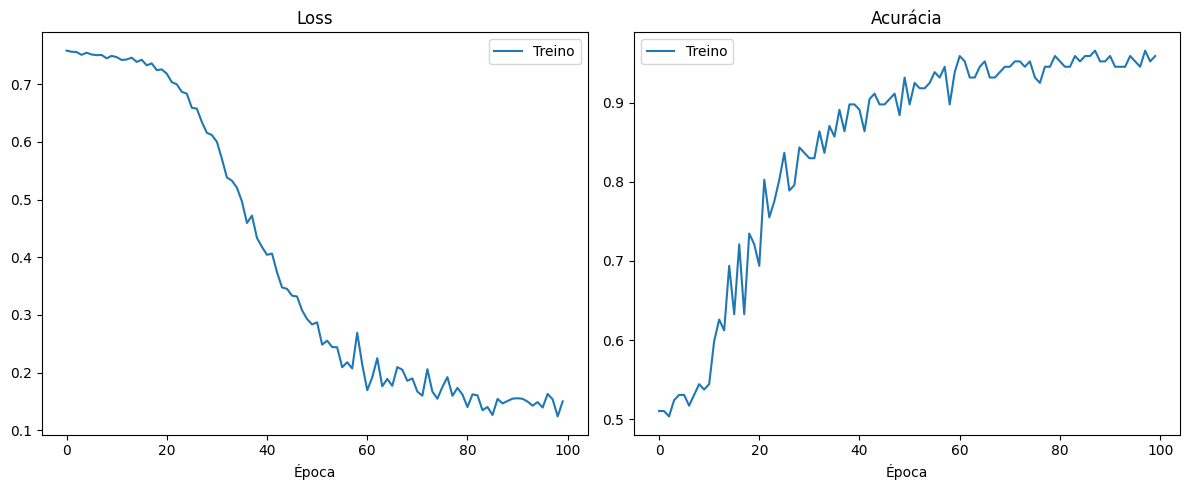

A fronteira de decisão só pode ser plotada para dados 2D.
A fronteira de decisão só pode ser plotada para dados 2D.


In [74]:
# Dataset de Treinamento
data = np.genfromtxt('C:/aprendizagem-de-maquina/datasets/train_dataset3.csv', delimiter=',', skip_header=1)
X_train = data[:, :-1]  # Features
y_train = data[:, -1]   # Labels
y_train = (y_train + 1) // 2

# Dataset de Teste
data = np.genfromtxt('C:/aprendizagem-de-maquina/datasets/test_dataset3.csv', delimiter=',', skip_header=1)
X_test = data[:, :-1]   # Features
y_test = data[:, -1]    # Labels
y_test = (y_test + 1) // 2

# Criar e treinar o modelo
mlp = MLPClassifier(optimizer='adam',
                    learning_rate=0.001,
                    hidden_layers=[9,9,9],
                    activation='relu',
                    regularization='dropout',
                    dropout_p=0.1)

# Treinar o modelo
mlp.fit(X_train, y_train)

# Avaliar no conjunto de teste
test_acc = mlp.evaluate(X_test, y_test)
print(f"\nAcurácia do Teste: {test_acc*100:.2f}%")

# Plotar histórico de treinamento
mlp.plot_training_history()

# Plotar fronteira de decisão (apenas para dados 2D)
mlp.plot_decision_boundary(X_train, y_train)
mlp.predict(X_test)
mlp.plot_decision_boundary(X_test, y_test)